Use the tweets for the updated vocab, test classifer on humor

In [1]:
!pwd

/home/farzin/haha_2019


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [5]:
PATH = Path('./data/rnn/')

In [6]:
all_texts_df = pd.read_csv('./data/haha_2019_train.csv')

In [7]:
all_texts_df.head()

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,funniness_average
0,705196579758583809,Niveles de retraso mental: \r\n\r\n— Bajo.\r\n...,1,1,2,2,0,0,0,1.5
1,678040651817213952,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1,3,0,1,0,0,1.5
2,546750892213829633,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,0,2,1,0,1,1,2.6
3,965807211292364801,No se porqué me hago la cabeza deooos,0,3,0,0,0,0,0,NaN
4,638403841839484928,Quisiera saber que hago durante la siesta de l...,0,4,0,1,0,0,0,NaN


In [8]:
all_texts_df.funniness_average.fillna(0,inplace=True)
all_texts_df.head()

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,funniness_average
0,705196579758583809,Niveles de retraso mental: \r\n\r\n— Bajo.\r\n...,1,1,2,2,0,0,0,1.5
1,678040651817213952,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1,3,0,1,0,0,1.5
2,546750892213829633,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,0,2,1,0,1,1,2.6
3,965807211292364801,No se porqué me hago la cabeza deooos,0,3,0,0,0,0,0,0.0
4,638403841839484928,Quisiera saber que hago durante la siesta de l...,0,4,0,1,0,0,0,0.0


### apply pre-rules to text

In [9]:
## New Line char for replacement in text
NL = 'xxnl'
defaults.text_spec_tok.append(NL) #add a New Line special char

def sub_nl(t:str) -> str:
    "Replaces \n by xxnl"
    return t.replace("\r\n","\n").replace("\n",NL+" ")

# def sub_br(t:str) -> str:
#     "Replaces the <br /> by \n"
#     re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
#     return re_br.sub("\n", t)

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#?!@,])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, 
                 rm_useless_spaces, sub_nl]

In [10]:
## apply the rules
raw_text = all_texts_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")

for rule in default_rules:
    print(rule)
    raw_text = raw_text.apply(lambda x: rule(str(x)))
    
all_texts_df['new_text'] =  raw_text #tokenizer adds xxbos

Default Rules:
 ['fixup', 'replace_rep', 'replace_wrep', 'deal_caps', 'spec_add_spaces', 'rm_useless_spaces', 'sub_nl'] 


<function fixup at 0x7f62bfc4c9d8>
<function replace_rep at 0x7f62bfc4c840>
<function replace_wrep at 0x7f62bfc4c8c8>
<function deal_caps at 0x7f62bfc4c950>
<function spec_add_spaces at 0x7f62bfc4c400>
<function rm_useless_spaces at 0x7f62bfc4c7b8>
<function sub_nl at 0x7f62bfc4c510>


In [11]:
all_texts_df['new_text'].head()

0    niveles de retraso mental: xxnl xxnl — bajo.xx...
1    —vamos luke desenfunda tu sable , demuestra tu...
2    - ¿te ofrezco algo ? , ¿agua , café , mi coraz...
3                no se porqué me hago la cabeza deooos
4    quisiera saber que hago durante la siesta de l...
Name: new_text, dtype: object

In [12]:
all_texts_df.shape

(24000, 11)

### Clean up the imbalanced data to balance

In [13]:
rnd_seed = 20190313
np.random.seed(rnd_seed)

idx = np.random.permutation(len(all_texts_df))
test_cut = int(0.15 * len(idx))
valid_cut = int(0.15 * len(idx-test_cut))

df_train_all = all_texts_df.iloc[idx[:-(valid_cut+test_cut)],:]
df_valid     = all_texts_df.iloc[idx[-(valid_cut+test_cut):-test_cut],:]
df_test      = all_texts_df.iloc[idx[-test_cut:],:]

### sp tokenizer from training

In [14]:
model_prefix = './all_tweets_es_0509'

In [15]:
## itos from m.vocab file: just read directly and populate the dictionary
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
#         itos[line_num] = line.split("\t")[0]
        itos.append(line.split("\t")[0])
        
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
#         return self.tok.EncodeAsIds(t)  ## tokenize + numericalize. We have them broken into two parts,just return tokens
        return self.tok.EncodeAsPieces(t)
        
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
    
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [16]:
itos[-10:]

['→', '😫', '🤨', '😲', '🏟', '📖', '🎸', '🏿', '😮', '🎬']

In [17]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix,pre_rules=default_rules)
sp_vocab = Vocab(itos)

In [18]:
data = TextClasDataBunch.from_df(PATH,df_train_all,df_valid,df_test,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='funniness_average')

In [19]:
data.show_batch(10)  #less xxunk, but still a fair amount...

text,target
▁ xxbos ▁❤ .- ~ * ( ▁? ▁el ▁di vo 00 ▁d 3 ▁tw 1 tter ▁! ▁! ▁! ▁? ▁? ▁~ k 3 ▁di 4 vl 0 zz ▁ki 3 r 3 z ▁k 3 ▁p 4 rt 3 ▁d 3 ▁no 00 ▁n 0 ▁3 nt 13 nd 3 z ▁b 3 the ▁k 0 n ▁ki 3 n ▁t 3 ▁d 3 ▁l 4 ▁g 4,0.0
▁ xxbos ▁dale ▁la ▁vuelta ▁a ▁tu ▁teléfono ▁ xxnl ▁ xxnl ▁ xxunk u xxunk s ▁ xxunk o xxunk d ▁n xxunk ▁ xxunk s ▁ xxunk ▁ xxunk ▁ xxunk s xxunk ▁s xxunk n xxunk ▁ol ▁ou ▁ xxunk s ▁ xxunk ou ▁ xxunk s xxunk ▁s xxunk u xxunk nq ▁s xxunk ou ▁ xxunk u xxunk ▁ xxunk ▁s xxunk ▁o xxunk s,0.0
"▁ xxbos ▁# ▁rt ▁ xxup ▁copia ▁y ▁ xxup ▁pega ▁en ▁ xxup ▁google ▁y ▁ve ▁la ▁ xxup ▁magia ▁sq rt ( cos ( x )) * cos ( 200 ▁x ) + sq rt ( abs ( x )) -. 07 ) * ( 4 - x * ▁x ) ^ 0. 01 ▁, ▁sq rt ( 9 - x ^ 2) ▁, ▁- sq rt (",0.0
▁ xxbos ▁qué ▁ricas ▁vacaciones ... xxnl ▁< xxunk / xxunk - xxunk ___ xxnl ▁/ < _ ▁/ ▁ xxrep ▁4 ▁_ ▁/ xxnl ▁ xxnl ▁no ▁ xxup ▁mames ▁ xxup ▁tengo ▁ xxup ▁que ▁ir ▁a ▁la ▁ xxup ▁escuela xxnl ▁ xxnl ▁ xxunk _ xxunk xxnl ▁( ・ xxunk ・ ) xxnl ▁_ | ▁ xxunk / ( ___ ▁ xxnl ▁/ ▁l ▁( __,0.0
▁ xxbos ▁ xxup ▁que ▁ xxup ▁pasó ▁ xxup ▁or ita ▁ xxup ▁boys ▁ xxup ▁los ▁ xxup ▁invitó ▁a ▁ xxup ▁que ▁ xxup ▁este ▁ xxup ▁viernes ▁le ▁ xxup ▁caigan ▁al ▁ xxup ▁suicidio ▁ xxup ▁colectivo ▁ xxup ▁banda ▁se ▁va ▁a ▁ xxup ▁poner ▁ xxup ▁bueno ▁ xxup ▁lleven ▁ xxup ▁sus ▁ xxup ▁propios ▁ xxup ▁u ten sil ios,0.0
"▁ xxbos ▁—¿ cómo ▁hace ▁la ▁oveja ▁? ▁ xxnl ▁— b ▁ xxrep ▁4 ▁e ▁. xxnl ▁—¿ y ▁la ▁oveja ▁negra ▁? ▁ xxnl ▁— ▁ xxup ▁yeah ▁ xxup ▁ni gga ▁, ▁ xxup ▁this ▁is ▁ xxup ▁the ▁ xxup ▁real ▁ xxup ▁shit ▁ xxup ▁m ada fa ka ▁ xxup ▁jajaja . xxnl ▁—¿ te ▁drogas ▁? ▁ xxnl ▁— a ▁diario .",1.8
▁ xxbos ▁¡ ▁ xxup ▁desde ▁el ▁ xxup ▁pasado ▁ xxup ▁jueves ▁ xxup ▁pague ▁la ▁ xxup ▁cajita ▁ xxup ▁clap ▁ xxup ▁que ▁ xxup ▁desde ▁ xxup ▁septiembre ▁no ▁ xxup ▁ven dian ▁en ▁mi ▁ xxup ▁barrio ▁ xxup ▁calle ▁ xxup ▁soledad ▁ xxup ▁sector ▁5 ▁ xxup ▁bocas ▁ xxup ▁cab im ás ▁y ▁ xxup ▁sin ▁ xxup ▁llegar ▁!,0.0
"▁ xxbos ▁—¿ qué ▁te ▁pasa ▁? ▁ xxnl ▁— nada ▁ xxnl ▁—¿ segura ▁? ▁ xxnl ▁— sí . ▁ xxnl ▁— ok ▁ xxnl ▁— ... xxnl ▁— bueno ▁me ▁voy . xxnl ▁— haz ▁lo ▁que ▁quieras ▁ xxup ▁imbécil ▁, ▁ xxup ▁ignor ame ▁ xxup ▁como ▁ xxup ▁siempre . xxnl ▁—¿ qué ▁te ▁pasa ▁? ▁ xxnl ▁— nada .",1.4615384
"▁ xxbos ▁— hola . xxnl ▁+ hola . ▁ xxnl ▁—¿ qué ▁tal ▁llevas ▁la ▁amnesia ▁? ▁ xxnl ▁+ hola . ▁ xxnl ▁— hola ▁, ▁¿ qué ▁tal ▁llevas ▁la ▁amnesia ▁? ▁ xxnl ▁+ bien ▁, ▁¿ y ▁tú ▁? ▁ xxnl ▁— bien . ▁ xxnl ▁+ ¿ el ▁qué ▁? ▁ xxnl ▁— la ▁amnesia . ▁ xxnl ▁+ hola .",1.1667
"▁ xxbos ▁ xxup ▁tengo ▁un ▁ xxup ▁gran ▁ xxup ▁anuncio ▁, ▁ xxup ▁una ▁ xxup ▁noticia ▁ xxup ▁que ▁ xxup ▁cambiará ▁la ▁ xxup ▁historia ▁de ▁ xxup ▁twitter ▁, ▁ xxup ▁que ▁ xxup ▁devolver á ▁el ▁ xxup ▁sentido ▁a ▁ xxup ▁nuestra ▁ xxup ▁vida . xxnl ▁ xxnl ▁ xxup ▁pendientes ▁ xxup ▁hoy ▁en ▁la ▁ xxup ▁noche",0.0


### Check `xxunk` fraction on humor data

In [20]:
pct_xxunk = pd.Series([sum(y==0)/len(y) for y in [x.data for x in data.train_dl.x]])
pct_xxunk[pct_xxunk>0].shape, pct_xxunk.shape

((415,), (16800,))

In [21]:
498/20704.

0.024053323029366306

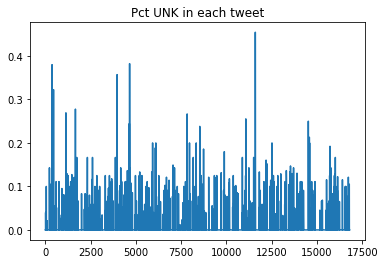

In [22]:
pd.Series([sum(y==0)/len(y) for y in [x.data for x in data.train_dl.x]]).plot()
_ = plt.title('Pct UNK in each tweet')

### build and train model

In [33]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 2304

learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
learn.load_encoder('twitter_es_enc_QRNN_0517_labelsmooth')

In [34]:
learn.loss_func

FlattenedLoss of MSELoss()

In [25]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


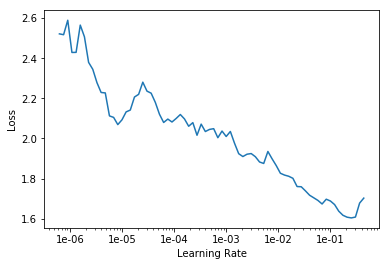

In [26]:
learn.recorder.plot(skip_end=5)

In [ ]:
learn.unfreeze()
## 0.7 drop
learn.fit_one_cycle(20, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.6), pct_start=0.25, div_factor=30.,
             callbacks=[SaveModelCallback(learn,every='improvement',mode='min',
                                          monitor='valid_loss',name='best_mse_model_Q')])

epoch,train_loss,valid_loss,time
0,1.035360,0.679260,00:14
1,0.808332,0.659964,00:15
2,0.762016,0.638135,00:15
3,0.717055,0.571713,00:15
4,0.782862,0.595547,00:14
5,0.670309,0.626590,00:15
6,0.628485,0.563793,00:15
7,0.751551,0.549994,00:14
8,0.663983,0.572609,00:14


Better model found at epoch 0 with valid_loss value: 0.6792596578598022.
Better model found at epoch 1 with valid_loss value: 0.659964382648468.
Better model found at epoch 2 with valid_loss value: 0.6381351947784424.
Better model found at epoch 3 with valid_loss value: 0.5717129707336426.
Better model found at epoch 6 with valid_loss value: 0.563792884349823.
Better model found at epoch 7 with valid_loss value: 0.5499940514564514.


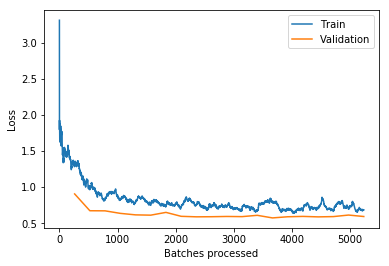

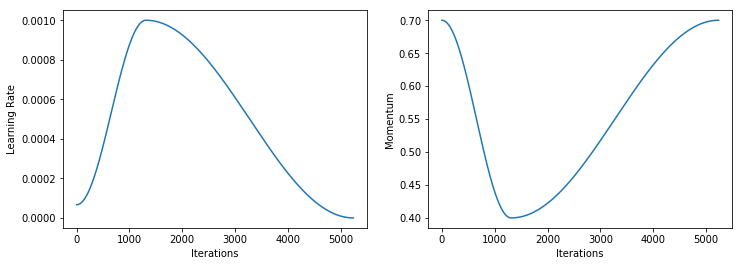

In [32]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)

In [33]:
learn.save('rnn_trained_unfreezeAll_funninessScore')

# Generate test file for submission

In [1]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df.head()

NameError: name 'pd' is not defined

In [ ]:
test_df.shape

In [ ]:
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

In [ ]:
data_tst = TextClasDataBunch.from_df(PATH, df_train, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [ ]:
learn.data = data_tst

In [ ]:
preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True)

In [ ]:
(preds_t.argmax(dim=1) == y_t).sum()

In [ ]:
## last years data must be part of this years train??  no way we did this well.
(2377+1347)/4000

In [ ]:
show_doc(FBeta)

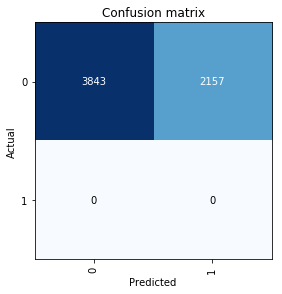

In [81]:
preds_tst,y_tst,losses_tst = learn.get_preds(DatasetType.Test,with_loss=True, ordered=True)
interp_t = ClassificationInterpretation(learn, preds_tst, y_tst, losses_tst)
interp_t.plot_confusion_matrix()

In [85]:
data_tst.test_ds.get(-1)

Text ▁ xxbos ▁¿ le ▁pusiste ▁a ▁tu ▁hijo ▁bec kh am ▁hace ▁16 ▁años ▁y ▁ahora ▁odia ▁el ▁fútbol ▁, ▁a ▁la ▁humanidad ▁y ▁a ▁ti ... ▁? ▁. ¡ normal ▁, ▁ya ▁hay ▁que ▁ser ▁gilipollas ▁! ▁.

In [92]:
test_df.head()

,id,text,new_text
0,tweet1,Historia #36.\n*Entra corriendo y gritando al ...,historia # 36.xxnl *entra corriendo y gritando...
1,tweet2,estoy tomando helado en el centro y pedi tiram...,estoy tomando helado en el centro y pedi tiram...
2,tweet3,— ¿De 15 o 20 centímetros?\n\n— Ven y averígua...,— ¿de 15 o 20 centímetros ? xxnl xxnl — ven y ...
3,tweet4,Que fea soy,que fea soy
4,tweet5,"#OMG, VAMOS EN RETROCESO RESULTE CON 40 SEGUID...","# xxup omg , xxup vamos en xxup retroceso xxu..."


In [48]:
out_cols = ['id','is_humor','funniness_average'] #need value in last col.  Try 3?

In [87]:
out_df = test_df['id'].to_frame().copy()

In [88]:
out_df['is_humor'] = to_np(preds_tst.argmax(dim=1))

In [90]:
out_df['funniness_average'] = 3.

In [93]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [97]:
out_df.to_csv('sub0520_1.csv',header=True,index=False)

In [98]:
!head sub0520_1.csv

id,is_humor,funniness_average
tweet1,1,3.0
tweet2,0,3.0
tweet3,1,3.0
tweet4,0,3.0
tweet5,0,3.0
tweet6,0,3.0
tweet7,0,3.0
tweet8,0,3.0
tweet9,0,3.0


In [100]:
!zip  sub0520_1.zip sub0520_1.csv 

  adding: sub0520_1.csv (deflated 84%)


In [101]:
!cp sub0520_1.zip /mnt/awcnas4_AWX/tmp/